# Viral proteins in bulk RNA seq data

[Open in Google Colab](https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/translated/notebooks/virus_detection_bulk.ipynb)

In this tutorial, we will align RNA sequencing data collected from SARS-CoV2 infected human iPSC derived cardiomyocytes to viral RdRP protein sequences. Let's see if we can detect SARS-CoV2 RdRP-like sequences as expected. This is a SMART-seq dataset, but the workflow is the same for bulk RNA sequencing data.

**Data references**:  
RNA seq data: https://www.cell.com/cell-reports-medicine/pdf/S2666-3791(20)30068-9.pdf  
PalmDB viral protein (RdRP) reference database:  https://www.nature.com/articles/s41586-021-04332-2  


Written by: Laura Luebbert (last updated: 12/28/2024)

In [1]:
# SRR numbers of the sequencing dataset(s) to analyze
srr_numbers = ["SRR11777734", "SRR11777735", "SRR11777736", "SRR11777737", "SRR11777738", "SRR11777739"]

# Here, we will only align a subset of [n_seq_to_keep] sequences from each of these SRRs
# to decrease the runtime of this example notebook
# Set n_seq_to_keep=False to align the complete dataset
n_seq_to_keep = 10000000

# Number of threads to use during alignments
threads = 2

# Increase k for increased specificity (at a potential trade-off with sensitivity)
# k should be an odd integer and should be >=31 for translated alignment
k = 55

## Install software

In [2]:
!pip install -q ffq gget kb_python==0.29.1 anndata==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB

In [3]:
import json
import glob
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
%config InlineBackend.figure_format='retina'

## Download the RNA sequencing data

In [4]:
# Get ftp download links for raw data with ffq and store results in json file
srr_numbers = " ".join(srr_numbers)
!ffq $srr_numbers \
    --ftp \
    -o ffq.json

# Load ffq output
f = open("ffq.json")
data_json = json.load(f)
f.close()

# Download raw data using FTP links fetched by ffq
for dataset in data_json:
    url = dataset["url"]
    !curl -O $url

[2024-12-27 20:53:29,938]    INFO Parsing run SRR11777734
[2024-12-27 20:53:32,376]    INFO Parsing run SRR11777735
[2024-12-27 20:53:33,946]    INFO Parsing run SRR11777736
[2024-12-27 20:53:35,753]    INFO Parsing run SRR11777737
[2024-12-27 20:53:37,217]    INFO Parsing run SRR11777738
[2024-12-27 20:53:38,754]    INFO Parsing run SRR11777739
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2962M  100 2962M    0     0  40.5M      0  0:01:13  0:01:13 --:--:-- 41.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2634M  100 2634M    0     0  40.4M      0  0:01:05  0:01:05 --:--:-- 41.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2484M  100 2484M

## Download the protein reference sequences
In this case, we are using a version of the [PalmDB database v1](https://github.com/ababaian/palmdb) that was optimized for viral sequence detection with kallisto as described in [this manuscript](https://www.biorxiv.org/content/10.1101/2023.12.11.571168). These files are stored in the [GitHub repository](https://github.com/pachterlab/LSCHWCP_2023/tree/main) accompanying the manuscript.

In [5]:
# Download the ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
# Download the customized transcripts to gene mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
# Download the RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa

--2024-12-27 21:01:04--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M  --.-KB/s    in 0.1s    

2024-12-27 21:01:04 (129 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]

--2024-12-27 21:01:05--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

## Build a reference index from the viral protein sequences and mask host (here, human) sequences

In addition to building a reference index from the protein sequences, we also want to mask host (in this case, human) sequences.

The [`--aa` argument](https://kallisto.readthedocs.io/en/latest/translated/pseudoalignment.html) tells `kb` that this is an amino acid reference.

The [`--d-list` argument](https://kallisto.readthedocs.io/en/latest/index/index_generation.html#the-d-list) is the path to the host genome/transcriptome. These sequences will be masked in the index. Here, we are using gget to fetch the latest human genome and transcriptome from Ensembl.

We are using `--workflow custom` here since we do not have a .gtf file for the PalmDB fasta file.

Building the index will take some time (runtimes vary from min to hours depending on k and the number of threads used), since the human genome is quite large.

In [6]:
# Download the human reference genome and transcriptome from Ensembl
# Replace 'homo_sapiens' here and the genome/transcriptome file names below if the host is a different species
!gget ref -w cdna,dna -d homo_sapiens

# Concatenate human genome and transcriptome into one file
!cat Homo_sapiens.GRCh38.cdna.all.fa.gz Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz > Homo_sapiens.GRCh38.cdna_dna.fa.gz

21:01:12 - INFO - Fetching reference information for homo_sapiens from Ensembl release: 113.
{
    "homo_sapiens": {
        "transcriptome_cdna": {
            "ftp": "http://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz",
            "ensembl_release": 113,
            "release_date": "2024-08-15",
            "release_time": "14:44",
            "bytes": "76M"
        },
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz",
            "ensembl_release": 113,
            "release_date": "2024-08-15",
            "release_time": "20:18",
            "bytes": "841M"
        }
    }
}
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75.9M  100 75.9M    0     0   675k      0  0:01:55  0:01:55 --:--:--  678k
  % Total    % Received %

In [7]:
%%time
# Generate the reference index using kallisto
!kb ref \
  --verbose \
  -t $threads \
  --aa \
  -k $k \
  --workflow custom \
  --d-list Homo_sapiens.GRCh38.cdna_dna.fa.gz \
  -i palmdb_human_dlist_cdna_dna.idx \
  palmdb_rdrp_seqs.fa

[2024-12-27 21:25:03,239]   DEBUG [main] Printing verbose output
[2024-12-27 21:25:05,449]   DEBUG [main] kallisto binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/kallisto/kallisto_k64
[2024-12-27 21:25:05,449]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2024-12-27 21:25:05,450]   DEBUG [main] Creating `tmp` directory
[2024-12-27 21:25:05,450]   DEBUG [main] Namespace(list=False, command='ref', tmp=None, keep_tmp=False, verbose=True, i='palmdb_human_dlist_cdna_dna.idx', g=None, f1=None, include_attribute=None, exclude_attribute=None, f2=None, c1=None, c2=None, d=None, k=55, t=2, d_list='Homo_sapiens.GRCh38.cdna_dna.fa.gz', d_list_overhang=1, aa=True, workflow='custom', distinguish=False, make_unique=False, overwrite=False, kallisto='/usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/kallisto/kallisto_k64', bustools='/usr/local/lib/python3.10/dist-packages/kb_python/bin

Alternatively, you can download a precomputed PalmDB reference index for use with `kb` in which the human (or mouse) genome and transcriptome were masked. You can find links to all available precomputed reference indeces [here](https://github.com/pachterlab/LSCHWCP_2023/tree/main/precomputed_refs).  
**Note:** These indeces were computed with `k=31`.

In [8]:
# # Download precomputed index with masked human genome and transcriptome
# k=31
# !wget https://data.caltech.edu/records/sh33z-hrx98/files/palmdb_human_dlist_cdna_dna.idx?download=1
# !mv palmdb_human_dlist_cdna_dna.idx?download=1 palmdb_human_dlist_cdna_dna.idx

## Align data using kallisto translated search

Create a batch file so we can run all fastq files simultaneously (to learn more about batch files, see Box 7 in the [Protocols paper](https://www.biorxiv.org/content/10.1101/2023.11.21.568164v2.full.pdf)):

In [9]:
if n_seq_to_keep:
    # To decrease the runtime of this example tutorial,
    # we will only align the top [n_seq_to_keep] sequences in each fastq file
    print(f"Number of reads kept per fastq file: {n_seq_to_keep:,}")

with open("batch.txt", "w") as batch_file:
  for filename in np.sort(glob.glob("*.fastq.gz")):

    if n_seq_to_keep:
        # Shorten fastq files (skip this step during a real analysis)
        n_rows_to_keep = n_seq_to_keep * 4
        filename_short = filename.split(".fastq.gz")[0] + "_short.fastq"
        !zcat $filename | head -$n_rows_to_keep > $filename_short
    else:
      filename_short = filename

    # Write batch file in the following format:
    # sample_name \t fastq_filepath
    sample_name = filename.split("/")[-1].split(".")[0]
    batch_file.write(sample_name + "\t" +  filename_short + "\n")

Number of reads kept per fastq file: 10,000,000


The `--aa` argument tells `kb` that this is an amino acid reference. The [`-x` argument](https://kallisto.readthedocs.io/en/latest/sc/technologies.html) tells `kb` where to find the barcodes and UMIs in the data.   
  
NOTE for paired read data: kallisto transalted search currently does not yet support the simultaneous alignment of paired reads, so `parity` should always be set to 'single' (`--parity single`) and the R1 and R2 files obtained using paired read sequencing should be aligned separately. The resulting matrices from the R1 and R2 reads should provide similar viral counts.

In [10]:
%%time

!kb count \
    --verbose \
    -t $threads \
    --aa \
    -k $k \
    -i palmdb_human_dlist_cdna_dna.idx \
    -g palmdb_clustered_t2g.txt \
    -x bulk \
    --parity single \
    --h5ad \
    -o kb_output \
    batch.txt

[2024-12-28 00:05:47,502]   DEBUG [main] Printing verbose output
[2024-12-28 00:05:49,712]   DEBUG [main] kallisto binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/kallisto/kallisto_k64
[2024-12-28 00:05:49,712]   DEBUG [main] bustools binary located at /usr/local/lib/python3.10/dist-packages/kb_python/bins/linux/bustools/bustools
[2024-12-28 00:05:49,713]   DEBUG [main] Creating `kb_output/tmp` directory
[2024-12-28 00:05:49,713]   DEBUG [main] Namespace(list=False, command='count', tmp=None, keep_tmp=False, verbose=True, i='palmdb_human_dlist_cdna_dna.idx', g='palmdb_clustered_t2g.txt', x='bulk', o='kb_output', num=False, w=None, r=None, t=2, m='2G', strand=None, inleaved=False, genomebam=False, aa=True, gtf=None, chromosomes=None, workflow='standard', em=False, mm=False, tcc=False, filter=None, filter_threshold=None, c1=None, c2=None, overwrite=False, dry_run=False, batch_barcodes=False, loom=False, h5ad=True, loom_names='barcode,target_name', sum='none

## Load generated count matrix

In [11]:
# Open count matrix generated by kb (AnnData object in h5ad format)
adata = anndata.read_h5ad("kb_output/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6 × 99228

## Plot counts for SARS-CoV RdRP sequences in each sample

In [12]:
# Load the PalmDB virus ID to virus taxonomy mapping
# Note: Only the rep_ID will occur in the reference index
u_tax_csv = "ID_to_taxonomy_mapping.csv"
tax_df = pd.read_csv(u_tax_csv)

# Find the reference IDs for SARS-CoV proteins
tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
404,u889,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
405,u9015,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
406,u944,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
407,u9771,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


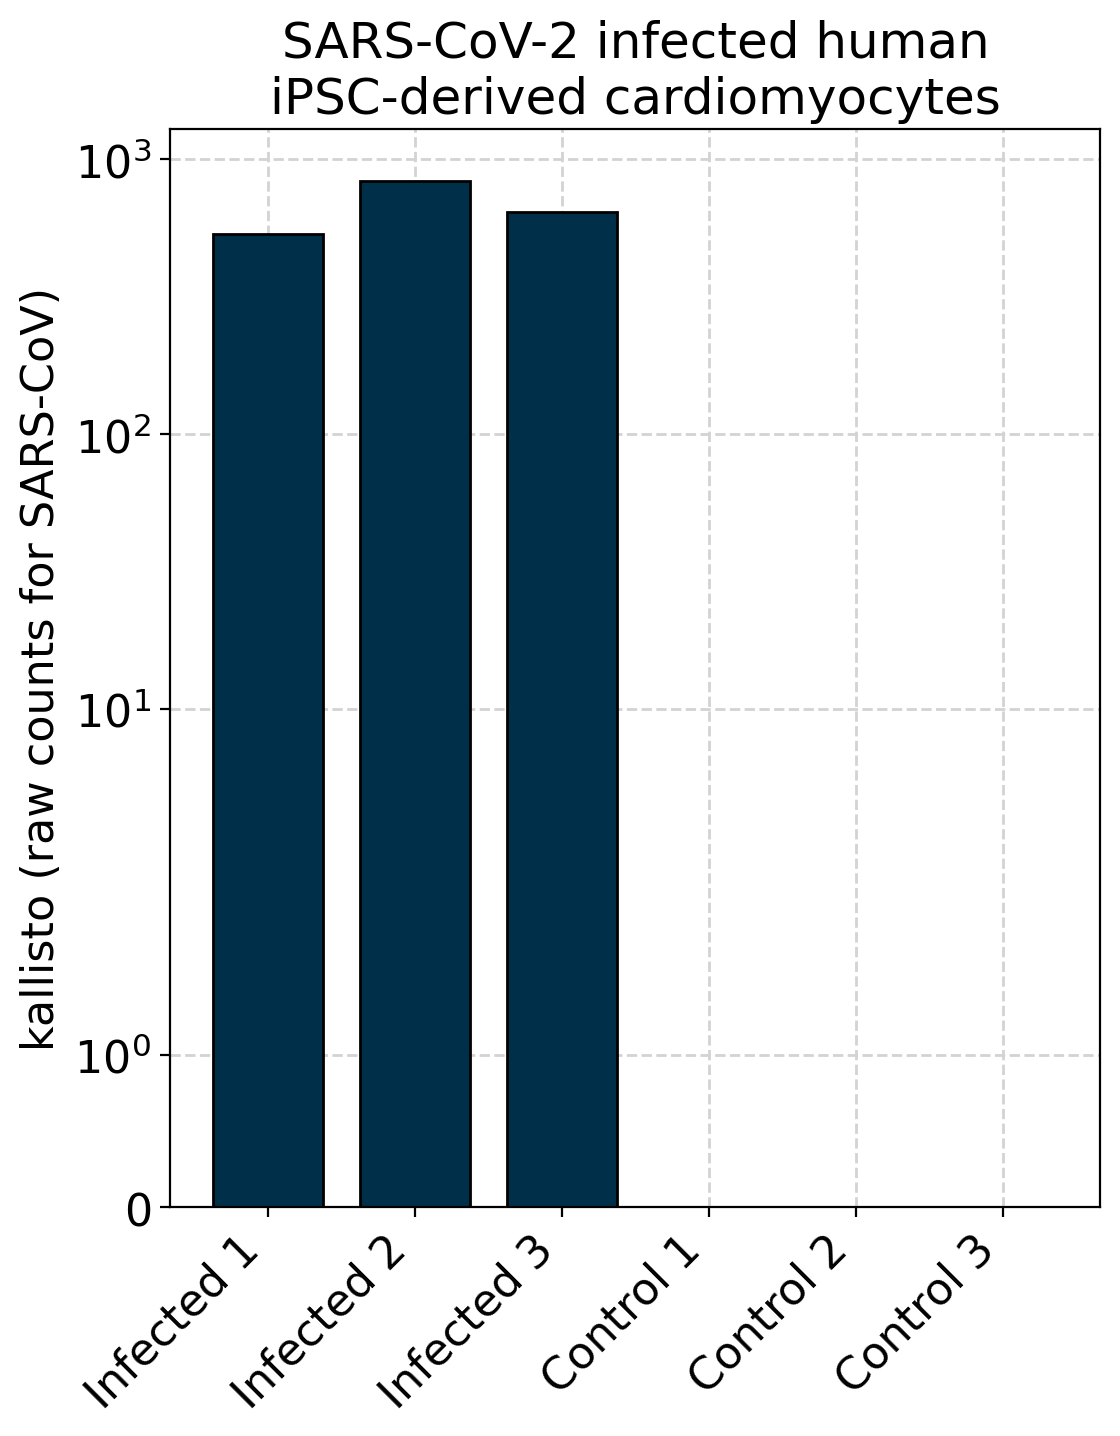

In [13]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 16
width = 0.75

# Since these were bulk sequencing samples, adata.obs.index is equivalent to the samples (SRR) files that were aligned
samples = np.sort(adata.obs.index.values)

# These labels match the ordered sample list
x_labels = ['Infected 1', 'Infected 2', 'Infected 3', 'Control 1', 'Control 2', 'Control 3']

# Target virus IDs to plot (here, SARS-CoV)
target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].unique()

# Plot total raw counts
counts = []
labels = samples
for sample in samples:
    counts.append(adata.X[adata.obs.index == sample, adata.var.index.isin(target_ids)].sum())

x = np.arange(len(labels))

ax.bar(x, counts, width=width, color="#003049", edgecolor="black")

ax.set_yscale("symlog")
ax.set_ylabel("kallisto (raw counts for SARS-CoV)", fontsize=fontsize)
# ax.set_xlabel("Sample", fontsize=fontsize)

ax.set_xticks(x, x_labels, rotation=45, ha="right")

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"SARS-CoV-2 infected human\niPSC-derived cardiomyocytes", fontsize=fontsize+2)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# Save figure
plt.savefig("sars_cov_rdrp_count.png", dpi=300, bbox_inches="tight")

fig.show()

In [14]:
counts

[534.0, 836.0, 642.0, 0.0, 0.0, 0.0]